# Uplift Random Forest

In [1]:
import sys
sys.path.append("/home/mori/Documents/h2o/env/h2o-env/lib/python3.7/site-packages")
sys.path.append("/home/mori/Documents/h2o/code/h2o-3/h2o-py/")

In [2]:
from causalml.dataset import make_uplift_classification
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

import numpy as np
import pandas as pd
from IPython.display import Image
from sklearn.model_selection import train_test_split

import h2o
from causalml.metrics import plot_gain, plot_qini, plot_lift
from causalml.metrics import auuc_score
from h2o.estimators.uplift_random_forest import H2OUpliftRandomForestEstimator

The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.


In [98]:
# Data generation
df, feature_cols = make_uplift_classification(n_samples=10000, 
                                              treatment_name=["control", "treatment"],
                                              n_classification_features=10,
                                              n_classification_informative=10)

# Rename features for easy interpretation of visualization
feature_cols_new = ['feature_%s'%(i) for i in range(len(feature_cols))]
rename_dict = {feature_cols[i]:feature_cols_new[i] for i in range(len(feature_cols))}
df = df.rename(columns=rename_dict)
feature_cols = feature_cols_new

print(df.head())

df.pivot_table(values='conversion',
               index='treatment_group_key',
               aggfunc=[np.mean, np.size],
               margins=True)

  treatment_group_key  feature_0  feature_1  feature_2  feature_3  feature_4  \
0           treatment   1.092147   0.273633   0.058737   0.832275   1.928096   
1             control  -0.970355  -0.582133   0.306262  -1.786951  -1.323988   
2             control  -2.082385   3.209135  -4.634873   0.370700  -1.327349   
3           treatment  -2.899760   3.321915  -1.174350   0.648730  -0.239345   
4           treatment   1.355526  -2.370844  -0.866364  -1.454662  -4.055121   

   feature_5  feature_6  feature_7  feature_8  feature_9  conversion  \
0   1.324736  -0.312059  -0.133680  -2.355057  -3.252217           0   
1  -2.180079   0.913340  -2.678207  -4.076631   2.700198           1   
2  -0.269335   1.202357   1.450558   0.788091  -0.649574           0   
3   2.816591   2.427054   2.806168   0.256660  -2.048109           0   
4  -1.147375   2.735377  -0.450756  -1.028439   2.279977           0   

   treatment_effect  
0                 0  
1                 0  
2                 0 

,mean,size
,conversion,conversion
treatment_group_key,,
control,0.4859,10000
treatment,0.5131,10000
All,0.4995,20000


In [99]:
# Split data to training and testing samples for model validation (next section)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=111)
df_train.shape, df_test.shape

((16000, 13), (4000, 13))

In [114]:
ntree = 100
max_depth = 15
control_name = "control"
treatment_column = "treatment_group_key"
response_column = "conversion"

## CausalML

In [115]:
# Train CausalML uplift tree
causalml_uplift_model = UpliftRandomForestClassifier(
        n_estimators=ntree,
        max_depth=max_depth,
        evaluationFunction='KL',
        control_name=control_name,
        min_samples_leaf=10,
        min_samples_treatment=10,
        normalization=False,
        random_state=42)

causalml_uplift_model.fit(df_train[feature_cols].values,
                 treatment=df_train[treatment_column].values,
                 y=df_train[response_column].values)

#df_test = df_train
causalml_preds = causalml_uplift_model.predict(df_test.values)

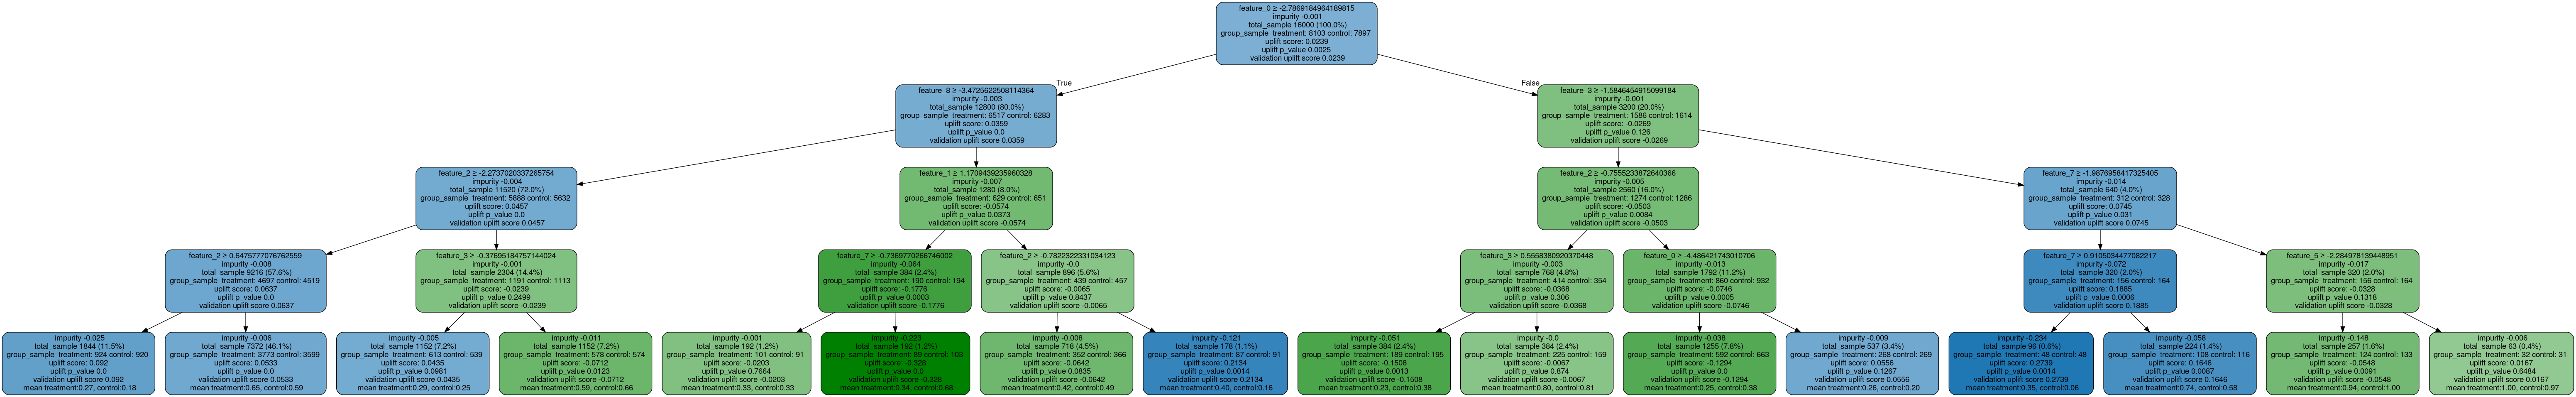

In [79]:
# Plot uplift tree
graph = uplift_tree_plot(causalml_uplift_model.uplift_forest[0].fitted_uplift_tree, feature_cols)
Image(graph.create_png())

In [9]:
# Plot uplift tree
graph = uplift_tree_plot(causalml_uplift_model.uplift_forest[1].fitted_uplift_tree, feature_cols)
img = Image(graph.create_png())

In [10]:
#for i in range(ntree):
#    graph = uplift_tree_plot(causalml_uplift_model.uplift_forest[i].fitted_uplift_tree, feature_cols)
#    with open("/home/mori/Documents/h2o/code/test/uplift/causal_tree/causal_tee_"+str(i)+".png", "wb") as fout:
#        fout.write(graph.create_png())

## H2O-3

In [ ]:
h2o.init(strict_version_check=False)

In [116]:
train_h2o = h2o.H2OFrame(df_train)
train_h2o[treatment_column] = train_h2o[treatment_column].asfactor()
train_h2o[response_column] = train_h2o[response_column].asfactor()
h2o_uplift_model = H2OUpliftRandomForestEstimator(
            ntrees=ntree,
            max_depth=max_depth-1,
            treatment_column=treatment_column,
            uplift_metric="KL",
            distribution="bernoulli",
            gainslift_bins=10,
            min_rows=10,
            nbins=1000,
            seed=42,
            sample_rate=0.99,
            auuc_type="gain"
)
h2o_uplift_model.train(y=response_column, x=feature_cols, training_frame=train_h2o)

Parse progress: |█████████████████████████████████████████████████████████| 100%
upliftdrf Model Build progress: |█████████████████████████████████████████| 100%


In [ ]:
# Print H2O tree using Graphviz
def plot_trees(model, tree_index=None, dot_path='/home/mori/Documents/h2o/code/test/quantile_constraints/tree.dot'):
    try:
        import graphviz
        mojo_path = model.download_mojo()
        mojo_dot = h2o.print_mojo(mojo_path, format='dot')

        with open(dot_path, 'a') as the_file:
            the_file.write(mojo_dot)
        
        return graphviz.Source(mojo_dot)
    except:
        print("Error occured, propably graphviz is not installed.")

In [ ]:
plot_trees(h2o_uplift_model)

In [ ]:
model = h2o_uplift_model
mojo_path = model.download_mojo()
# print mojo fails
#mojo_dot = h2o.print_mojo(mojo_path, format='dot')

In [ ]:
from h2o.tree import H2OTree, H2ONode

In [ ]:
tree = H2OTree(h2o_uplift_model, 4, 1)
print(tree.tree_decision_path)

In [ ]:
tree = H2OTree(h2o_uplift_model, 0, 0)
print(tree.tree_decision_path)

In [117]:
test_h2o = h2o.H2OFrame(df_test)
preds_h2o = h2o_uplift_model.predict(test_h2o)
preds_h2o

Parse progress: |█████████████████████████████████████████████████████████| 100%
upliftdrf prediction progress: |██████████████████████████████████████████| 100%


uplift_predict,p_y1_ct1,p_y1_ct0
0.02758,0.517487,0.489907
0.02758,0.517487,0.489907
0.02758,0.517487,0.489907
0.02758,0.517487,0.489907
0.02758,0.517487,0.489907
0.02758,0.517487,0.489907
0.0245058,0.513988,0.489483
0.02758,0.517487,0.489907
0.02758,0.517487,0.489907
0.02758,0.517487,0.489907


In [118]:
preds_comp = preds_h2o["uplift_predict"]
preds_comp.names = ["h2o"]
preds_comp["causal"] = h2o.H2OFrame(causalml_preds)
preds_comp["diff"] = abs(preds_comp["h2o"] - preds_comp["causal"])
preds_comp[treatment_column] = h2o.H2OFrame(df_test[treatment_column].values)
preds_comp[response_column] = h2o.H2OFrame(df_test[response_column].values)
preds_comp.summary()
    
min_diff = preds_comp["diff"].min()
max_diff = preds_comp["diff"].max()
mean_diff = preds_comp["diff"].mean(return_frame=False)[0]
print("min: %f max: %f mean: %f" % (min_diff, max_diff, mean_diff))

results = preds_comp.as_data_frame()
results = results[["h2o", "causal", response_column, treatment_column]]
mapping = {'control': 0, 'treatment': 1}
results = results.replace({treatment_column: mapping})


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


,h2o,causal,diff,treatment_group_key,conversion
type,real,real,real,enum,int
mins,-0.14410311102867135,-0.15351450999999983,2.754616548195088e-07,,0.0
mean,0.028114397583147495,-0.003064131544999974,0.04033077269768127,,0.497
maxs,0.28387071877717973,0.15382532,0.2887808287771797,,1.0
sigma,0.017016856076611568,0.03711506302606151,0.031185192071313216,,0.5000535105149694
zeros,0,0,0,,2012
missing,0,0,0,0,0
0,0.0275800454616546,0.013861000000000012,0.013719045461654589,treatment,1.0
1,0.0275800454616546,-0.033485330000000035,0.061065375461654636,treatment,0.0
2,0.0275800454616546,0.015521620000000014,0.012058425461654587,control,1.0


min: 0.000000 max: 0.288781 mean: 0.040331


In [119]:
auuc = auuc_score(results, outcome_col=response_column, treatment_col=treatment_column, normalize=False)
print("H2O AUUC:")
print(auuc["h2o"])
print("CauslML AUUC:")
print(auuc["causal"])
print("Random AUUC:")
print(auuc["Random"])

H2O AUUC:
34.26095177948445
CauslML AUUC:
55.385412058316696
Random AUUC:
50.38891795721606


In [120]:
perf_h2o = h2o_uplift_model.model_performance(test_h2o)
auuc_h2o = perf_h2o.auuc()
print("H2O training metrics AUUC Gain: "+str(auuc_h2o))


H2O training metrics AUUC Gain: 84.27280339159857


In [121]:
n, uplift = perf_h2o.plot_auuc(metric="qini", plot=False)
print(len(n))
print(len(uplift))

319
319


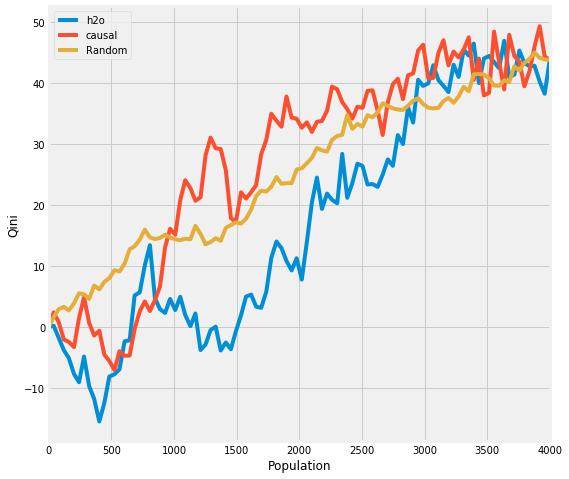

In [122]:
plot_qini(results, outcome_col=response_column, treatment_col=treatment_column)

[2, 3, 4, 6, 6, 7, 8, 10, 11, 12, 15, 15, 16, 18, 20, 20, 21, 26, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 38, 38, 39, 41, 44, 44, 45, 47, 47, 49, 60, 60, 65, 66, 67, 69, 69, 70, 72, 72, 74, 75, 77, 77, 78, 83, 83, 84, 86, 86, 87, 88, 90, 92, 92, 93, 94, 3865, 3865, 3867, 3867, 3868, 3911, 3912, 3917, 3917, 3918, 3923, 3923, 3924, 3931, 3931, 3933, 3933, 3935, 3937, 3937, 3938, 3958, 3958, 3962, 3962, 3968, 3968, 3973, 3973, 3974, 3979, 3979, 3980, 3981, 3982, 3985, 3985, 3986, 3987, 3988, 3989, 3990, 3992, 3993, 3995, 3995, 3996, 3997, 3998, 4000]
[-1.0, -0.5, -0.3333333333333333, 1.0, 1.0, 0.5, 0.8, 1.6666666666666667, 1.2857142857142858, 1.8571428571428572, 1.0, 1.0, 0.40000000000000036, 0.18181818181818166, -0.6666666666666661, -0.6666666666666661, -1.25, -2.8571428571428568, -2.8571428571428568, -3.428571428571429, -3.8000000000000007, -3.3125, -2.88235294117647, -2.4117647058823524, -2.0, -2.8947368421052637, -3.25, -3.8000000000000007, -3.0, -3.0, -3.5, -3.391304347826088, -3.120

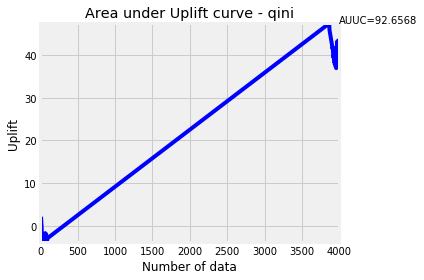

In [109]:
print(n)
print(uplift)
perf_h2o.plot_auuc(metric="qini")

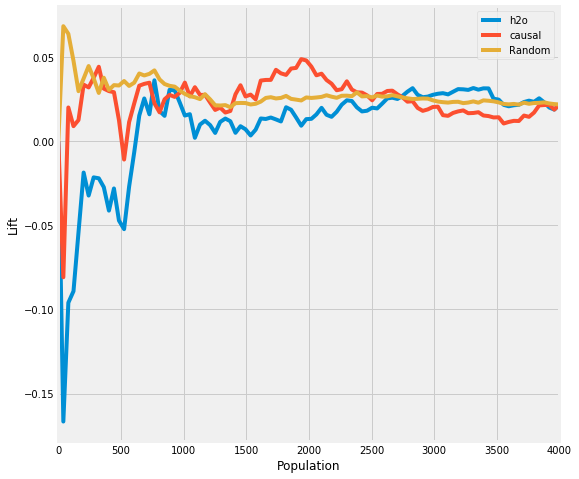

In [110]:
plot_lift(results, outcome_col=response_column, treatment_col=treatment_column)


[2, 3, 4, 6, 6, 7, 8, 10, 11, 12, 15, 15, 16, 18, 20, 20, 21, 26, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 38, 38, 39, 41, 44, 44, 45, 47, 47, 49, 60, 60, 65, 66, 67, 69, 69, 70, 72, 72, 74, 75, 77, 77, 78, 83, 83, 84, 86, 86, 87, 88, 90, 92, 92, 93, 94, 3865, 3865, 3867, 3867, 3868, 3911, 3912, 3917, 3917, 3918, 3923, 3923, 3924, 3931, 3931, 3933, 3933, 3935, 3937, 3937, 3938, 3958, 3958, 3962, 3962, 3968, 3968, 3973, 3973, 3974, 3979, 3979, 3980, 3981, 3982, 3985, 3985, 3986, 3987, 3988, 3989, 3990, 3992, 3993, 3995, 3995, 3996, 3997, 3998, 4000]
[-1.0, -0.5, -0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.16666666666666663, 0.2666666666666666, 0.4166666666666667, 0.32142857142857145, 0.3714285714285715, 0.20000000000000007, 0.20000000000000007, 0.06666666666666665, 0.025974025974025983, -0.08333333333333337, -0.08333333333333337, -0.13888888888888895, -0.23809523809523808, -0.23809523809523808, -0.2637362637362637, -0.29230769230769227, -0.2548076923076923, -0.22171945

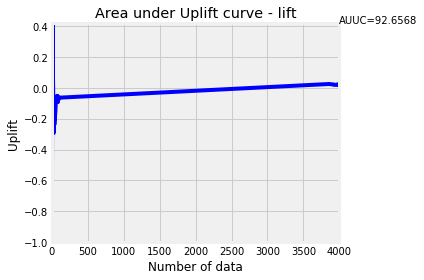

In [111]:
n, uplift = perf_h2o.plot_auuc(metric="lift", plot=False)
print(n)
print(uplift)
perf_h2o.plot_auuc(metric="lift")

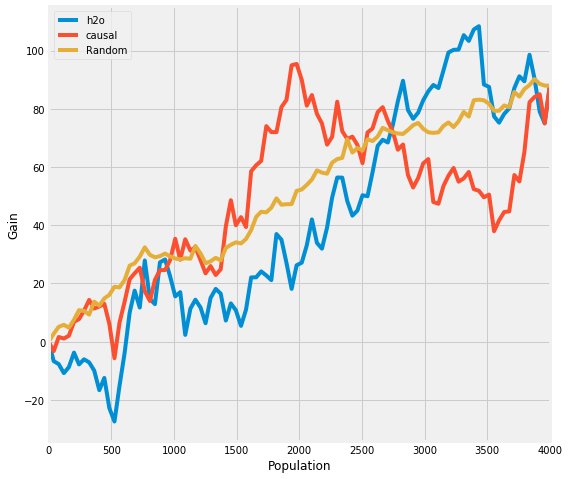

In [112]:
plot_gain(results, outcome_col=response_column, treatment_col=treatment_column)

[2, 3, 4, 6, 6, 7, 8, 10, 11, 12, 15, 15, 16, 18, 20, 20, 21, 26, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 38, 38, 39, 41, 44, 44, 45, 47, 47, 49, 60, 60, 65, 66, 67, 69, 69, 70, 72, 72, 74, 75, 77, 77, 78, 83, 83, 84, 86, 86, 87, 88, 90, 92, 92, 93, 94, 3865, 3865, 3867, 3867, 3868, 3911, 3912, 3917, 3917, 3918, 3923, 3923, 3924, 3931, 3931, 3933, 3933, 3935, 3937, 3937, 3938, 3958, 3958, 3962, 3962, 3968, 3968, 3973, 3973, 3974, 3979, 3979, 3980, 3981, 3982, 3985, 3985, 3986, 3987, 3988, 3989, 3990, 3992, 3993, 3995, 3995, 3996, 3997, 3998, 4000]
[-2.0, -1.5, -1.3333333333333333, 2.0, 2.0, 1.1666666666666665, 2.133333333333333, 4.166666666666667, 3.535714285714286, 4.457142857142858, 3.000000000000001, 3.000000000000001, 1.0666666666666664, 0.4675324675324677, -1.6666666666666674, -1.6666666666666674, -2.916666666666668, -6.19047619047619, -6.19047619047619, -7.12087912087912, -8.184615384615384, -7.389423076923077, -6.651583710407239, -5.340336134453781, -4.571428571428571, -6.561403

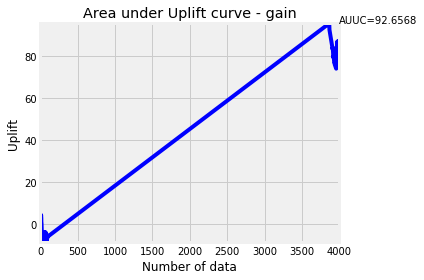

In [113]:
n, uplift = perf_h2o.plot_auuc(metric="gain", plot=False)
print(n)
print(uplift)
perf_h2o.plot_auuc(metric="gain")